In [1]:
!pip install requests fredapi pandas schedule

In [2]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
from scipy import interpolate
from statsmodels import robust

# BLS API configuration
BLS_API_KEY = "58d8a969b3424879b55320f337696d8a"  # Replace with your BLS API key
BLS_BASE_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# JOLTS series IDs with human-readable names
jolt_series = {
    "JTS000000000000000JOL": "Total_Nonfarm_Job_Openings",
    "JTS300000000000000JOL": "Manufacturing_Job_Openings",
    "JTS600000000000000JOL": "Professional_Services_Job_Openings",
    "JTS700000000000000JOL": "Leisure_Hospitality_Job_Openings",
}

# def clean_series(df, column='value'):
#     """
#     Clean series by handling missing values, non-numeric values, and outliers.
#     """
#     df[column] = pd.to_numeric(df[column], errors='coerce')
#     df[column] = df[column].ffill().bfill()

#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

#     if df[column].isna().any():
#         print(f"Warning: {column} has {df[column].isna().sum()} NaN values after cleaning")

#     return df

def interpolate_to_weekly(df, date_col='date', value_col='value', method='linear'):
    """
    Interpolate series to weekly frequency.
    """
    df[date_col] = pd.to_datetime(df[date_col])
    df_clean = df.dropna(subset=[value_col]).copy()

    if df_clean.empty:
        print(f"Warning: No valid data for interpolation")
        return None

    start_date = df_clean[date_col].min()
    end_date = df_clean[date_col].max()
    weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    df_clean.loc[:, 'numeric_date'] = (df_clean[date_col] - df_clean[date_col].min()).dt.days

    try:
        if method == 'cubic':
            interp_func = interpolate.interp1d(df_clean['numeric_date'], df_clean[value_col], kind='cubic', fill_value="extrapolate")
            interpolated_values = interp_func((weekly_dates - start_date).days)
        else:  # linear
            interp_func = interpolate.interp1d(df_clean['numeric_date'], df_clean[value_col], kind='linear', fill_value="extrapolate")
            interpolated_values = interp_func((weekly_dates - start_date).days)

        interpolated_df = pd.DataFrame({
            date_col: weekly_dates,
            value_col: interpolated_values
        })
        return interpolated_df
    except Exception as e:
        print(f"Interpolation failed for method {method}: {e}")
        return None

def fetch_bls_data(series_ids, start_year=2000, end_year=datetime.now().year):
    """
    Fetch BLS JOLTS data in decade-long batches, interpolate to weekly, and combine into a single DataFrame.
    Returns a pandas DataFrame with weekly data and human-readable columns.
    """
    headers = {"Content-type": "application/json"}
    all_combined_dfs = []

    # Define decade ranges
    current_year = min(end_year, datetime.now().year)
    year_ranges = []
    year = start_year
    while year <= current_year:
        decade_start = year
        decade_end = min(year + 9, current_year)
        year_ranges.append((decade_start, decade_end))
        year = decade_end + 1

    for start_y, end_y in year_ranges:
        print(f"Fetching BLS JOLTS data for {start_y}-{end_y}...")
        payload = {
            "seriesid": list(series_ids.keys()),
            "startyear": str(start_y),
            "endyear": str(end_y),
            "registrationkey": BLS_API_KEY
        }

        weekly_dfs = []

        try:
            # Fetch data from BLS API
            response = requests.post(BLS_BASE_URL, json=payload, headers=headers)
            response.raise_for_status()
            data = response.json()

            if data["status"] != "REQUEST_SUCCEEDED":
                raise Exception(f"API error for {start_y}-{end_y}: {data['message']}")

            # Process each series
            for series in data["Results"]["series"]:
                series_id = series["seriesID"]
                series_name = jolt_series[series_id]
                print(f"Processing {series_id} ({series_name}) for {start_y}-{end_y}...")

                # Extract data points
                results = []
                for item in series["data"]:
                    try:
                        results.append({
                            "series_id": series_id,
                            "sector": series_name,
                            "date": f"{item['year']}-{item['period'][1:]}-01",
                            "value": float(item["value"])
                        })
                    except (ValueError, KeyError) as e:
                        print(f"Warning: Skipping invalid data point for {series_id}: {e}")
                        continue

                if not results:
                    print(f"Warning: No valid data for {series_id} ({series_name}) in {start_y}-{end_y}")
                    continue

                df = pd.DataFrame(results)
                df["date"] = pd.to_datetime(df["date"])

                # Check and remove duplicates
                duplicates = df[df.duplicated(subset=['date', 'series_id'], keep=False)]
                if len(duplicates) > 0:
                    print(f"Warning: {series_id} ({series_name}) has {len(duplicates)} duplicates in {start_y}-{end_y}")
                    df = df.groupby(['date', 'series_id']).agg({'value': 'mean', 'sector': 'first'}).reset_index()

                # Interpolate to weekly
                print(f"Interpolating {series_name} to weekly for {start_y}-{end_y}...")
                interpolated_df = interpolate_to_weekly(df, method='linear')
                if interpolated_df is not None:
                    #interpolated_df = clean_series(interpolated_df)
                    weekly_dfs.append(interpolated_df.rename(columns={"value": series_name}))

            # Combine weekly DataFrames for this decade
            if weekly_dfs:
                combined_df = weekly_dfs[0]
                for df in weekly_dfs[1:]:
                    combined_df = combined_df.merge(df, on='date', how='outer')
                all_combined_dfs.append(combined_df)

        except Exception as e:
            print(f"Error fetching BLS data for {start_y}-{end_y}: {e}")
            print("Check API key at https://www.bls.gov/developers/api_faqs.htm or data availability.")
            continue

    # Combine all decade DataFrames
    if all_combined_dfs:
        final_df = pd.concat(all_combined_dfs, axis=0, ignore_index=True)
        final_df = final_df.groupby('date').first().reset_index()  # Remove any overlapping dates
        final_df = final_df.set_index('date').sort_index()

        # Fill missing values
        final_df = final_df.ffill().bfill()

        # Remove any duplicate dates
        final_df = final_df.loc[~final_df.index.duplicated(keep='last')]

        # Verify columns
        expected_columns = list(jolt_series.values())
        missing_columns = [col for col in expected_columns if col not in final_df.columns]
        if missing_columns:
            print(f"Warning: Missing columns: {missing_columns}")

        print("BLS JOLTS data processed successfully")
        return final_df.reset_index()
    else:
        print("No BLS JOLTS data processed")
        return None

bls_data = fetch_bls_data(jolt_series, start_year=2000)
if bls_data is not None:
    print("BLS JOLTS Weekly Data Sample:")
    print(bls_data.head())
    print(f"Columns: {bls_data.columns.tolist()}")

Fetching BLS JOLTS data for 2000-2009...
Processing JTS000000000000000JOL (Total_Nonfarm_Job_Openings) for 2000-2009...
Interpolating Total_Nonfarm_Job_Openings to weekly for 2000-2009...
Processing JTS300000000000000JOL (Manufacturing_Job_Openings) for 2000-2009...
Interpolating Manufacturing_Job_Openings to weekly for 2000-2009...
Processing JTS600000000000000JOL (Professional_Services_Job_Openings) for 2000-2009...
Interpolating Professional_Services_Job_Openings to weekly for 2000-2009...
Processing JTS700000000000000JOL (Leisure_Hospitality_Job_Openings) for 2000-2009...
Interpolating Leisure_Hospitality_Job_Openings to weekly for 2000-2009...
Fetching BLS JOLTS data for 2010-2019...
Processing JTS000000000000000JOL (Total_Nonfarm_Job_Openings) for 2010-2019...
Interpolating Total_Nonfarm_Job_Openings to weekly for 2010-2019...
Processing JTS300000000000000JOL (Manufacturing_Job_Openings) for 2010-2019...
Interpolating Manufacturing_Job_Openings to weekly for 2010-2019...
Processi

Plotting BLS JOLTS data in notebook...
BLS JOLTS Weekly Data Sample:
        date  Total_Nonfarm_Job_Openings  Manufacturing_Job_Openings  \
0 2000-12-04                 5102.129032                  426.935484   
1 2000-12-11                 5135.096774                  431.451613   
2 2000-12-18                 5168.064516                  435.967742   
3 2000-12-25                 5201.032258                  440.483871   
4 2001-01-01                 5234.000000                  445.000000   

   Professional_Services_Job_Openings  Leisure_Hospitality_Job_Openings  
0                          911.548387                        574.516129  
1                          894.161290                        594.387097  
2                          876.774194                        614.258065  
3                          859.387097                        634.129032  
4                          842.000000                        654.000000  
Columns: ['date', 'Total_Nonfarm_Job_Openings', 'Manuf

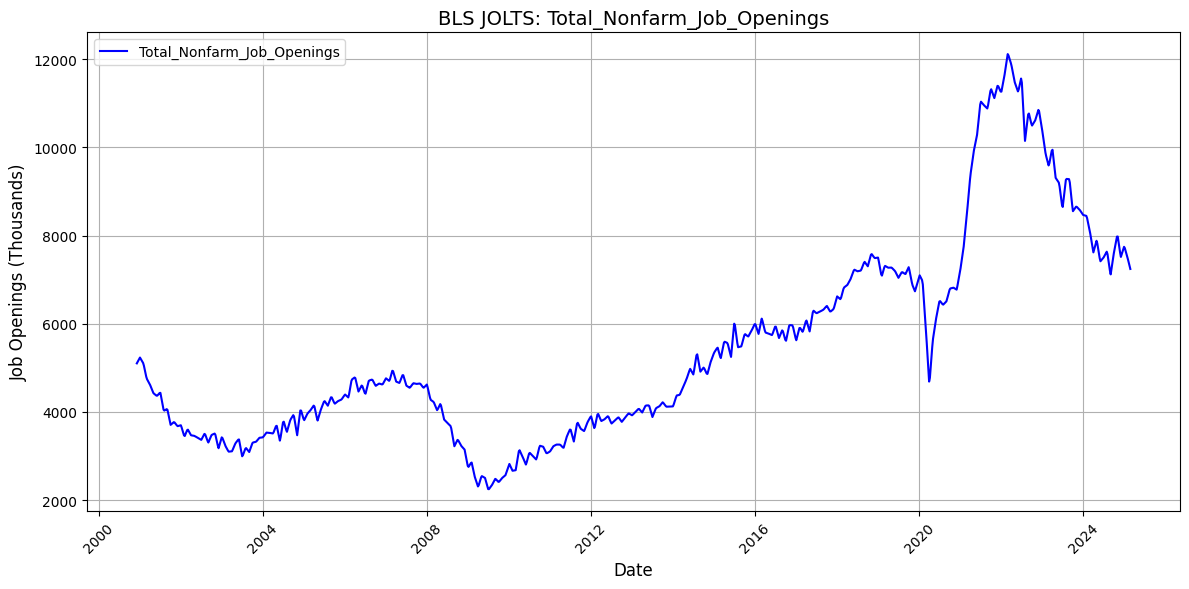

Displayed plot for: Total_Nonfarm_Job_Openings


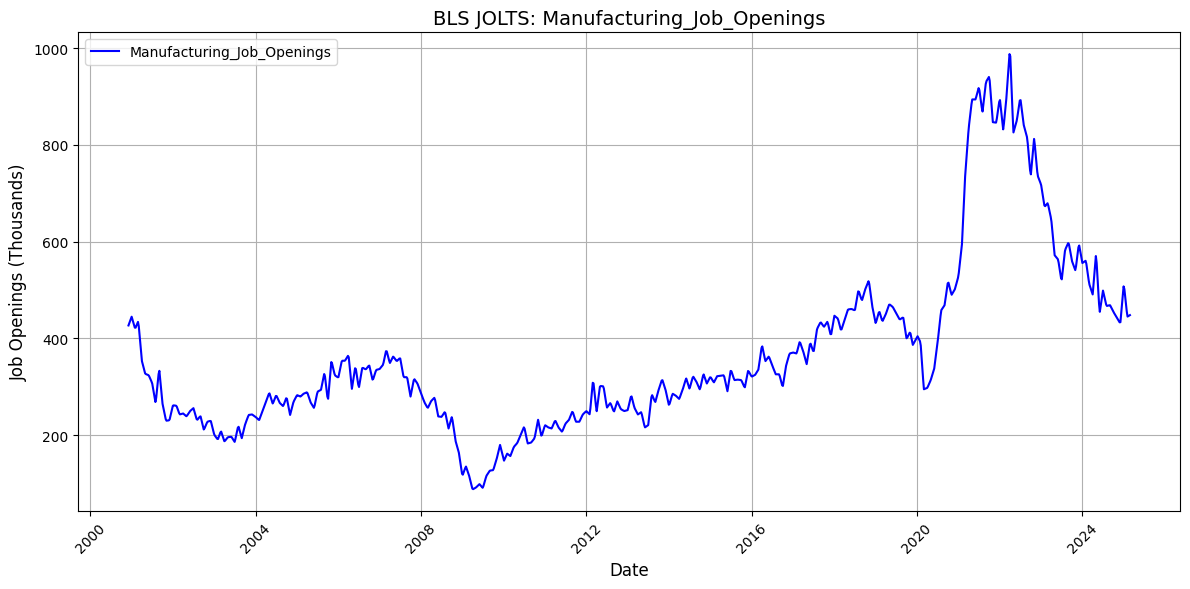

Displayed plot for: Manufacturing_Job_Openings


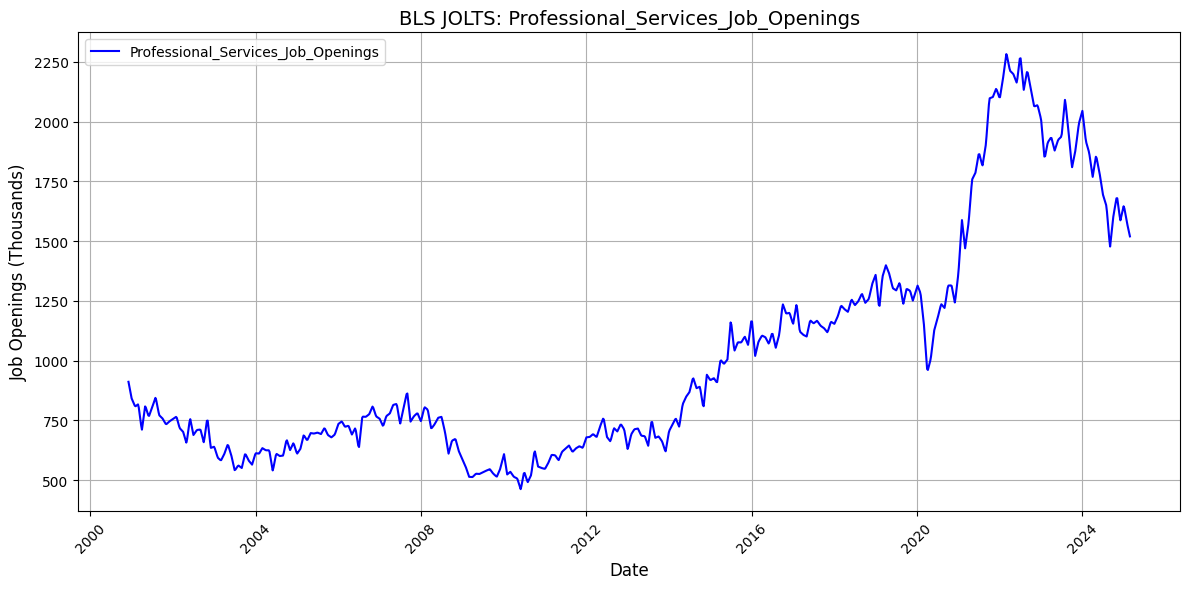

Displayed plot for: Professional_Services_Job_Openings


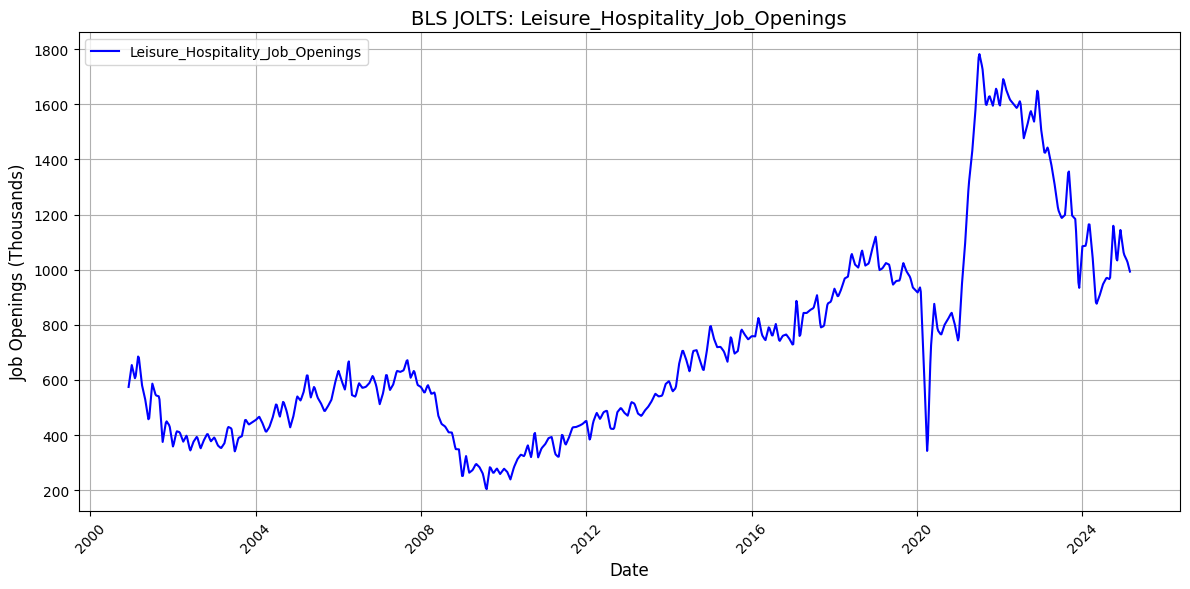

Displayed plot for: Leisure_Hospitality_Job_Openings


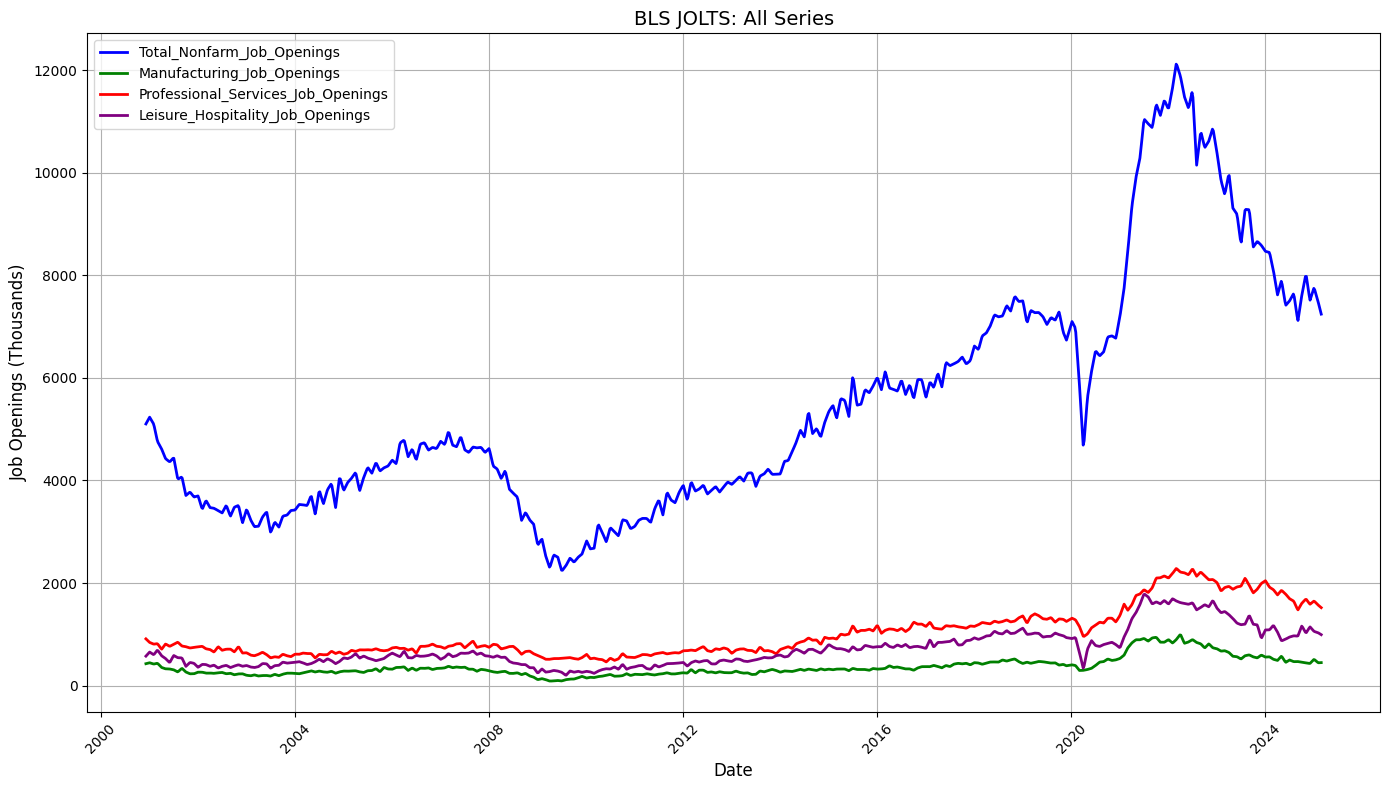

Displayed combined plot for all JOLTS series


In [3]:
# Ensure matplotlib plots are displayed inline in the notebook
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

def plot_bls_data_notebook(bls_data):
    """
    Plot initial actual BLS JOLTS data in a Jupyter notebook.
    Displays individual plots for each series and a combined plot.

    Parameters:
    - bls_data: DataFrame with 'date' column (datetime) and JOLTS series columns.
    """
    # Ensure 'date' is datetime
    bls_data['date'] = pd.to_datetime(bls_data['date'])

    # Get JOLTS series columns (exclude 'date')
    series_columns = [col for col in bls_data.columns if col != 'date']

    # Plot 1: Individual plots for each series
    for col in series_columns:
        plt.figure(figsize=(12, 6))
        plt.plot(bls_data['date'], bls_data[col], label=col, color='blue')
        plt.title(f'BLS JOLTS: {col}', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Job Openings (Thousands)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()  # Display plot in notebook
        print(f"Displayed plot for: {col}")

    # Plot 2: Combined plot for all series
    plt.figure(figsize=(14, 8))
    colors = ['blue', 'green', 'red', 'purple']  # Distinct colors for each series
    for i, col in enumerate(series_columns):
        plt.plot(bls_data['date'], bls_data[col], label=col, linewidth=2, color=colors[i % len(colors)])
    plt.title('BLS JOLTS: All Series', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Job Openings (Thousands)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()  # Display combined plot
    print("Displayed combined plot for all JOLTS series")

# Example usage (assuming bls_data is available from fetch_bls_data)
if bls_data is not None:
    print("Plotting BLS JOLTS data in notebook...")
    print("BLS JOLTS Weekly Data Sample:")
    print(bls_data.head())
    print(f"Columns: {bls_data.columns.tolist()}")
    plot_bls_data_notebook(bls_data)
else:
    print("Error: bls_data is None. Please ensure fetch_bls_data ran successfully.")

In [4]:
import pandas as pd
import numpy as np
from fredapi import Fred
from datetime import datetime
from scipy import interpolate
from statsmodels import robust

# FRED API configuration
FRED_API_KEY = "8fc0d8bd4ea5422e403a182588e4920a"  # Replace with your FRED API key
fred = Fred(api_key=FRED_API_KEY)

# FRED series IDs with human-readable names and frequencies
fred_series = {

    "ICSA": {"name": "Initial_Jobless_Claims", "frequency": "weekly"},
    "PAYEMS": {"name": "Total_Nonfarm_Employment", "frequency": "monthly"},
    "UNRATE": {"name": "Unemployment_Rate", "frequency": "monthly"},
    "MANEMP": {"name": "Manufacturing_Employment", "frequency": "monthly"},
    "USPBS": {"name": "Professional_Services_Employment", "frequency": "monthly"},
    "USLAH": {"name": "Leisure_Hospitality_Employment", "frequency": "monthly"},
    "CES0500000003": {"name": "Average_Hourly_Earnings", "frequency": "monthly"},
    "AWHAETP": {"name": "Weekly_Hours_Worked", "frequency": "monthly"},
    "GDPC1": {"name": "GDP", "frequency": "quarterly"},
    "CSUSHPINSA": {"name": "Housing_Prices", "frequency": "monthly"},
    "FEDFUNDS": {"name": "Federal_Funds_Rate", "frequency": "monthly"}
}

def clean_series(df, column='value'):
    """
    Clean series by handling missing values, non-numeric values, and outliers.
    """
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column] = df[column].ffill().bfill()

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    if df[column].isna().any():
        print(f"Warning: {column} has {df[column].isna().sum()} NaN values after cleaning")

    return df

def interpolate_to_weekly(df, date_col='date', value_col='value', method='linear'):
    """
    Interpolate series to weekly frequency.
    """
    df[date_col] = pd.to_datetime(df[date_col])
    df_clean = df.dropna(subset=[value_col]).copy()

    if df_clean.empty:
        print(f"Warning: No valid data for interpolation")
        return None

    start_date = df_clean[date_col].min()
    end_date = df_clean[date_col].max()
    weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    df_clean.loc[:, 'numeric_date'] = (df_clean[date_col] - df_clean[date_col].min()).dt.days

    try:
        if method == 'cubic':
            interp_func = interpolate.interp1d(df_clean['numeric_date'], df_clean[value_col], kind='cubic', fill_value="extrapolate")
            interpolated_values = interp_func((weekly_dates - start_date).days)
        else:  # linear
            interp_func = interpolate.interp1d(df_clean['numeric_date'], df_clean[value_col], kind='linear', fill_value="extrapolate")
            interpolated_values = interp_func((weekly_dates - start_date).days)

        interpolated_df = pd.DataFrame({
            date_col: weekly_dates,
            value_col: interpolated_values
        })
        return interpolated_df
    except Exception as e:
        print(f"Interpolation failed for method {method}: {e}")
        return None

def fetch_fred_data(series_ids, start_year=2000, end_year=datetime.now().year):
    """
    Fetch FRED data, separate by frequency, interpolate to weekly, and combine into a single DataFrame.
    Ensures SP500 is included as a separate column and prevents sector column issues.
    Returns a pandas DataFrame with weekly data and human-readable columns.
    """
    daily_dfs = []
    non_daily_dfs = []

    # Fetch and categorize series by frequency
    for series_id, info in series_ids.items():
        series_name = info["name"]
        frequency = info["frequency"]

        try:
            # Fetch series data with debugging
            print(f"Fetching {series_id} ({series_name})...")
            data = fred.get_series(series_id, observation_start=f"{start_year}-01-01", observation_end=f"{end_year}-12-31")

            if data is None or data.empty:
                print(f"Warning: No data returned for {series_id} ({series_name})")
                if series_id == "SP500":
                    print("SP500 fetch failed. Check API key permissions at https://fredaccount.stlouisfed.org/apikeys or data availability.")
                continue

            # Log data summary
            print(f"Data for {series_id}: {len(data)} rows, first few values: {data.head().to_list()}")

            # Convert to DataFrame
            df = data.reset_index().rename(columns={"index": "date", 0: "value"})
            df["series_id"] = series_id
            df["sector"] = series_name
            df["date"] = pd.to_datetime(df["date"])
            df["value"] = pd.to_numeric(df["value"], errors="coerce")

            # Check for valid data
            valid_count = df["value"].notna().sum()
            if valid_count < len(df) * 0.1:  # Allow partial data
                print(f"Warning: {series_id} ({series_name}) has only {valid_count} valid values out of {len(df)}")
                continue

            # Check and remove duplicates
            duplicates = df[df.duplicated(subset=['date', 'series_id'], keep=False)]
            if len(duplicates) > 0:
                print(f"Warning: {series_id} ({series_name}) has {len(duplicates)} duplicates")
                print(duplicates.head())
                df = df.groupby(['date', 'series_id']).agg({'value': 'mean', 'sector': 'first'}).reset_index()

            # Categorize by frequency
            if frequency == "daily":
                daily_dfs.append(df)
            else:
                non_daily_dfs.append(df)

        except Exception as e:
            print(f"Error fetching {series_id} ({series_name}): {e}")
            if series_id == "SP500":
                print("SP500 fetch failed. Check API key permissions at https://fredaccount.stlouisfed.org/apikeys or data availability.")
            continue

    # Process daily data (aggregate to weekly)
    weekly_dfs = []
    for df in daily_dfs:
        series_name = df["sector"].iloc[0]
        print(f"Aggregating daily data for {series_name} to weekly...")

        # Fill missing days (e.g., weekends for SP500)
        df = df.set_index('date').resample('D').ffill().reset_index()
        df = df.resample('W-MON', on='date').mean(numeric_only=True).reset_index()

        if df.empty or df["value"].isna().all():
            print(f"Warning: No valid weekly data for {series_name} after aggregation")
            if series_name == "SP500":
                print("SP500 aggregation failed. Verify data availability or API response.")
            continue

        df = clean_series(df)
        # Rename to ensure SP500 is a data column, not sector
        weekly_dfs.append(df[['date', 'value']].rename(columns={"value": series_name}))

    # Process non-daily data (interpolate to weekly)
    for df in non_daily_dfs:
        series_name = df["sector"].iloc[0]
        frequency = [info["frequency"] for series_id, info in series_ids.items() if info["name"] == series_name][0]

        # Choose interpolation method
        method = 'cubic' if frequency == "quarterly" else 'linear'

        print(f"Interpolating {series_name} ({frequency}) to weekly with {method} method...")
        interpolated_df = interpolate_to_weekly(df, method=method)
        if interpolated_df is not None:
            interpolated_df = clean_series(interpolated_df)
            # Rename to ensure data column, not sector
            weekly_dfs.append(interpolated_df[['date', 'value']].rename(columns={"value": series_name}))

    # Combine all weekly DataFrames
    if weekly_dfs:
        # Merge on date, preserving all dates
        combined_df = weekly_dfs[0]
        for df in weekly_dfs[1:]:
            combined_df = combined_df.merge(df, on='date', how='outer')

        # Set date as index and fill missing values
        combined_df = combined_df.set_index('date').sort_index()
        combined_df = combined_df.ffill().bfill()

        # Remove any duplicate dates
        combined_df = combined_df.loc[~combined_df.index.duplicated(keep='last')]

        # Verify columns, especially SP500
        expected_columns = [info["name"] for series_id, info in series_ids.items()]
        missing_columns = [col for col in expected_columns if col not in combined_df.columns]
        if missing_columns:
            print(f"Warning: Missing columns: {missing_columns}")
            if "SP500" in missing_columns:
                print("SP500 missing in final DataFrame. Verify API key at https://fredaccount.stlouisfed.org/apikeys or data availability.")

        print("FRED data processed successfully")
        return combined_df.reset_index()
    else:
        print("No FRED data processed")
        return None

fred_data = fetch_fred_data(fred_series, start_year=2000)
if fred_data is not None:
    print("FRED Weekly Data Sample:")
    print(fred_data.head())
    print(f"Columns: {fred_data.columns.tolist()}")

Fetching ICSA (Initial_Jobless_Claims)...
Data for ICSA: 1322 rows, first few values: [286000.0, 298000.0, 289000.0, 284000.0, 285000.0]
Fetching PAYEMS (Total_Nonfarm_Employment)...
Data for PAYEMS: 304 rows, first few values: [131011.0, 131121.0, 131604.0, 131883.0, 132105.0]
Fetching UNRATE (Unemployment_Rate)...
Data for UNRATE: 304 rows, first few values: [4.0, 4.1, 4.0, 3.8, 4.0]
Fetching MANEMP (Manufacturing_Employment)...
Data for MANEMP: 304 rows, first few values: [17284.0, 17284.0, 17302.0, 17299.0, 17278.0]
Fetching USPBS (Professional_Services_Employment)...
Data for USPBS: 304 rows, first few values: [16488.0, 16525.0, 16599.0, 16682.0, 16647.0]
Fetching USLAH (Leisure_Hospitality_Employment)...
Data for USLAH: 304 rows, first few values: [11713.0, 11719.0, 11788.0, 11834.0, 11827.0]
Fetching CES0500000003 (Average_Hourly_Earnings)...
Data for CES0500000003: 230 rows, first few values: [20.05, 20.15, 20.13, 20.23, 20.29]
Fetching AWHAETP (Weekly_Hours_Worked)...
Data for

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels import robust


# def clean_series(df, column, fill_missing=True):
#     """
#     Clean series by handling non-numeric values and outliers.
#     Optionally skip filling missing values for BLS columns.
#     """
#     df[column] = pd.to_numeric(df[column], errors='coerce')

#     if fill_missing:
#         df[column] = df[column].ffill().bfill()

#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

#     if df[column].isna().any():
#         print(f"Warning: {column} has {df[column].isna().sum()} NaN values after cleaning")

#     return df

def preprocess_data(start_year=2000, end_year=datetime.now().year):
    """
    Fetch FRED and BLS data, combine into a single weekly DataFrame starting from the first overlapping date,
    and produce df_2000 (from overlap to present) and df_2006 (2006–present).
    Uses inner merge and avoids filling missing BLS data.
    Returns two DataFrames: df_2000, df_2006.
    """


    if fred_data is None or bls_data is None:
        print("Error: Failed to fetch FRED or BLS data")
        return None, None

    # Ensure date is datetime
    fred_data['date'] = pd.to_datetime(fred_data['date'])
    bls_data['date'] = pd.to_datetime(bls_data['date'])

    # Debugging: Data summary
    print("\nFRED Data Summary:")
    print(f"Shape: {fred_data.shape}")
    print(f"Columns: {fred_data.columns.tolist()}")
    print(f"Date Range: {fred_data['date'].min()} to {fred_data['date'].max()}")

    print("\nBLS Data Summary:")
    print(f"Shape: {bls_data.shape}")
    print(f"Columns: {bls_data.columns.tolist()}")
    print(f"Date Range: {bls_data['date'].min()} to {bls_data['date'].max()}")

    # Check for duplicate dates
    for df, name in [(fred_data, "FRED"), (bls_data, "BLS")]:
        duplicates = df[df['date'].duplicated(keep=False)]
        if len(duplicates) > 0:
            print(f"Warning: {name} data has {len(duplicates)} duplicate dates")
            print(duplicates.head())
            df = df.groupby('date').mean(numeric_only=True).reset_index()

    # Merge FRED and BLS data using inner merge
    print("\nMerging FRED and BLS data from first overlapping date...")
    combined_df = pd.merge(fred_data, bls_data, on='date', how='inner')
    combined_df = combined_df.sort_values('date').set_index('date')

    # Clean columns, filling missing values only for FRED columns
    fred_columns = [info["name"] for series_id, info in fred_series.items()]
    bls_columns = list(jolt_series.values())

    for column in combined_df.columns:
        fill_missing = column in fred_columns  # Only fill for FRED columns
        # combined_df = clean_series(combined_df, column, fill_missing=fill_missing)

    # Remove any duplicate dates
    combined_df = combined_df.loc[~combined_df.index.duplicated(keep='last')]

    # Verify columns
    expected_columns = fred_columns + bls_columns
    missing_columns = [col for col in expected_columns if col not in combined_df.columns]
    if missing_columns:
        print(f"Warning: Missing columns in combined DataFrame: {missing_columns}")

    # Debugging: Combined DataFrame summary
    print("\nCombined DataFrame Summary:")
    print(f"Shape: {combined_df.shape}")
    print(f"Columns: {combined_df.columns.tolist()}")
    print(f"Date Range: {combined_df.index.min()} to {combined_df.index.max()}")

    # Create df_2000 and df_2006
    df_2000 = combined_df.reset_index()

    # Filter for df_2006 (2006–present)
    df_2006 = combined_df[combined_df.index >= '2006-01-01'].reset_index()

    # Verify data quality
    for df, name in [(df_2000, "df_2000"), (df_2006, "df_2006")]:
        print(f"\n{name} Summary:")
        print(f"Shape: {df.shape}")
        print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
        duplicates = df[df['date'].duplicated(keep=False)]
        if len(duplicates) > 0:
            print(f"Warning: {name} has {len(duplicates)} duplicate dates")
            print(duplicates.head())
        # Check for NaN values
        nan_counts = df[bls_columns].isna().sum()
        if nan_counts.any():
            print(f"Warning: {name} has NaN values in BLS columns:")
            print(nan_counts[nan_counts > 0])

    print("Data preprocessing completed successfully")
    return df_2000, df_2006

df_2000, df_2006 = preprocess_data(start_year=2000)
if df_2000 is not None and df_2006 is not None:
    print("\ndf_2000 Sample:")
    print(df_2000.head())
    print(f"df_2000 Columns: {df_2000.columns.tolist()}")
    print("\ndf_2006 Sample:")
    print(df_2006.head())
    print(f"df_2006 Columns: {df_2006.columns.tolist()}")


FRED Data Summary:
Shape: (1321, 12)
Columns: ['date', 'Initial_Jobless_Claims', 'Total_Nonfarm_Employment', 'Unemployment_Rate', 'Manufacturing_Employment', 'Professional_Services_Employment', 'Leisure_Hospitality_Employment', 'Average_Hourly_Earnings', 'Weekly_Hours_Worked', 'GDP', 'Housing_Prices', 'Federal_Funds_Rate']
Date Range: 2000-01-03 00:00:00 to 2025-04-21 00:00:00

BLS Data Summary:
Shape: (1256, 5)
Columns: ['date', 'Total_Nonfarm_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings', 'Leisure_Hospitality_Job_Openings']
Date Range: 2000-12-04 00:00:00 to 2025-02-24 00:00:00

Merging FRED and BLS data from first overlapping date...

Combined DataFrame Summary:
Shape: (1256, 15)
Columns: ['Initial_Jobless_Claims', 'Total_Nonfarm_Employment', 'Unemployment_Rate', 'Manufacturing_Employment', 'Professional_Services_Employment', 'Leisure_Hospitality_Employment', 'Average_Hourly_Earnings', 'Weekly_Hours_Worked', 'GDP', 'Housing_Prices', 'Federal_Fund

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.tsatools import detrend
import warnings
import time

warnings.filterwarnings("ignore")
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate MAPE (mean absolute percentage error).
    Avoids division by zero by filtering out zero values.
    """
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def check_stationarity(series, name, threshold=0.05):
    """
    Perform ADF test to check stationarity after detrending.
    Return True if stationary, False otherwise.
    """
    try:
        detrended = detrend(series.dropna(), order=1)
        result = adfuller(detrended)
        p_value = result[1]
        print(f"ADF Test for {name} (after detrending): p-value = {p_value:.4f}")
        return p_value < threshold
    except ValueError as e:
        print(f"Cannot perform ADF test for {name}: {e}")
        return False

def preprocess_series(df):
    """
    Apply log transformation to high-variance series and add noise to zero-variance series.
    Return transformed DataFrame and list of log-transformed columns.
    """
    transformed_df = df.copy()
    log_columns = []

    for col in transformed_df.columns:
        std_val = transformed_df[col].std()
        print(f"Standard deviation of {col}: {std_val:.6f}")

        # Add small noise to zero-variance series
        if std_val == 0:
            print(f"Adding small noise to {col} (zero variance)")
            transformed_df[col] = transformed_df[col] + np.random.normal(0, 1e-6, len(transformed_df[col]))

        # Log transform high-variance series
        if std_val > 5000:
            if (transformed_df[col] > 0).all():
                print(f"Applying log transformation to {col} (high variance)")
                transformed_df[col] = np.log(transformed_df[col])
                log_columns.append(col)

    return transformed_df, log_columns

def make_stationary(df, threshold=0.05, seasonal_period=0):
    """
    Apply seasonal differencing and regular differencing to non-stationary series.
    Return differenced DataFrame, list of differenced columns, and seasonal differenced columns.
    """
    diff_df = df.copy()
    diff_columns = []
    seasonal_diff_columns = []

    for col in diff_df.columns:
        # Seasonal differencing (if seasonal_period > 0)
        if seasonal_period > 0 and len(diff_df[col]) > seasonal_period:
            print(f"Applying seasonal differencing (lag {seasonal_period}) to {col}...")
            diff_df[col] = diff_df[col].diff(seasonal_period)
            seasonal_diff_columns.append(col)

        # Check stationarity
        if not check_stationarity(diff_df[col].dropna(), col, threshold):
            print(f"Differencing {col}...")
            diff_df[col] = diff_df[col].diff().dropna()
            diff_columns.append(col)

    return diff_df.dropna(), diff_columns, seasonal_diff_columns

def inverse_transform(forecast, original_df, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period=0):
    """
    Reverse differencing, seasonal differencing, and log transformation to get forecasts in original scale.
    """
    result = forecast.copy()

    # Reverse seasonal differencing (if applied)
    if seasonal_period > 0:
        for col in seasonal_diff_columns:
            if col in result.columns:
                seasonal_start_idx = max(0, test_start_idx - seasonal_period)
                seasonal_base = original_df[col].iloc[seasonal_start_idx:test_start_idx]
                if len(seasonal_base) < seasonal_period:
                    seasonal_base = pd.Series([seasonal_base.iloc[0]] * (seasonal_period - len(seasonal_base))).append(seasonal_base, ignore_index=True)
                seasonal_result = []
                for i in range(len(result)):
                    idx = i % seasonal_period
                    seasonal_result.append(seasonal_base.iloc[idx] + result[col].iloc[:i+1].sum())
                result[col] = pd.Series(seasonal_result, index=result.index)

    # Reverse regular differencing
    for col in diff_columns:
        if col in result.columns:
            start_value = original_df[col].iloc[test_start_idx-1]
            result[col] = start_value + forecast[col].cumsum()

    # Reverse log transformation
    for col in log_columns:
        if col in result.columns:
            result[col] = np.exp(result[col])

    return result

def run_var_model(df_stationary, df, df_no_date, forecast_horizon, window_size, maxlags, seasonal_period, diff_columns, seasonal_diff_columns, log_columns):
    """
    Run a single VAR model with given parameters and return MAE and runtime.
    """
    start_time = time.time()

    initial_window = int(len(df_stationary) * window_size)
    step_size = forecast_horizon
    forecasts = []
    actuals = []
    forecast_dates = []
    key_vars = ['Total_Nonfarm_Job_Openings']

    print(f"\nRolling window forecasting (window size: {initial_window}, horizon: {forecast_horizon}, maxlags: {maxlags}, seasonal_period: {seasonal_period})")

    for start in range(initial_window, len(df_stationary), step_size):
        train_end = start
        test_start = start
        test_end = min(start + forecast_horizon, len(df_stationary))

        train = df_stationary.iloc[:train_end]
        test = df_stationary.iloc[test_start:test_end]

        try:
            model = VAR(train)
            lag_order = model.select_order(maxlags=maxlags).aic
            print(f"Selected lag order (AIC): {lag_order}")
            results = model.fit(lag_order)
        except ValueError as e:
            print(f"Error fitting VAR: {e}")
            print("Reducing lag order to 1...")
            model = VAR(train)
            results = model.fit(1)
            lag_order = 1

        forecast_steps = len(test)
        forecast = results.forecast(train.values[-lag_order:], steps=forecast_steps)
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)

        test_start_idx = df.index[train_end]
        forecast_levels = inverse_transform(forecast_df, df_no_date, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period)
        test_levels = inverse_transform(test, df_no_date, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period)

        forecasts.append(forecast_levels)
        actuals.append(test_levels)
        forecast_dates.extend(df['date'].iloc[test_start:test_end])

    forecast_all = pd.concat(forecasts)
    actual_all = pd.concat(actuals)

    # Compute MAE for Total_Nonfarm_Job_Openings
    mae = mean_absolute_error(actual_all['Total_Nonfarm_Job_Openings'], forecast_all['Total_Nonfarm_Job_Openings'])
    runtime = time.time() - start_time

    return mae, runtime, forecast_all, actual_all, forecast_dates

def simple_var_model(df, forecast_horizon=4, window_size=0.8):
    """
    Test multiple seasonal periods and lag orders to find the best fit VAR model.
    """
    # Verify data size and columns
    print(f"\nInput df_2000: {len(df)} rows, {len(df.columns)} columns")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Date range: {pd.to_datetime(df['date']).min()} to {pd.to_datetime(df['date']).max()}")

    if 'date' not in df.columns:
        print("Error: 'date' column missing in df_2000")
        return None, None, None

    df['date'] = pd.to_datetime(df['date'])

    # Preprocess series
    df_no_date = df.drop(columns=['date'])
    df_transformed, log_columns = preprocess_series(df_no_date)
    print(f"Log-transformed columns: {log_columns}")

    # Test multiple seasonal periods and maxlags
    seasonal_periods = [ 0,13,26,52]  # 0 (none), quarterly, semi-annual, annual
    maxlags_values = [2, 4, 6, 8]
    results = []
    key_vars = ['Total_Nonfarm_Job_Openings', 'Manufacturing_Job_Openings',
                'Professional_Services_Job_Openings', 'Leisure_Hospitality_Job_Openings']

    for seasonal_period in seasonal_periods:
        # Apply seasonal differencing for the current period
        df_stationary, diff_columns, seasonal_diff_columns = make_stationary(df_transformed, threshold=0.05, seasonal_period=seasonal_period)
        print(f"Differenced columns: {diff_columns}")
        print(f"Seasonally differenced columns: {seasonal_diff_columns}")

        if df_stationary.empty or len(df_stationary.columns) < 2:
            print(f"Error: Insufficient valid series for VAR modeling with seasonal_period={seasonal_period}")
            continue

        for maxlags in maxlags_values:
            print(f"\nTesting seasonal_period={seasonal_period}, maxlags={maxlags}")
            mae, runtime, forecast_all, actual_all, forecast_dates = run_var_model(
                df_stationary, df, df_no_date, forecast_horizon, window_size, maxlags,
                seasonal_period, diff_columns, seasonal_diff_columns, log_columns
            )
            results.append({
                'seasonal_period': seasonal_period,
                'maxlags': maxlags,
                'mae': mae,
                'runtime': runtime,
                'forecast_all': forecast_all,
                'actual_all': actual_all,
                'forecast_dates': forecast_dates
            })
            print(f"MAE (Total_Nonfarm_Job_Openings): {mae:.2f}, Runtime: {runtime:.2f} seconds")

    # Find best configuration
    best_result = min(results, key=lambda x: x['mae'])
    print(f"\nBest Configuration: seasonal_period={best_result['seasonal_period']}, maxlags={best_result['maxlags']}")
    print(f"Best MAE (Total_Nonfarm_Job_Openings): {best_result['mae']:.2f}, Runtime: {best_result['runtime']:.2f} seconds")

    # Compute detailed accuracy for best configuration
    forecast_all = best_result['forecast_all']
    actual_all = best_result['actual_all']
    forecast_dates = best_result['forecast_dates']

    print("\nModel Accuracy for Best Configuration (on level values, rolling window):")
    print("\nModel Accuracy for Best Configuration (on level values, rolling window):")
    for var in key_vars:
        if var in actual_all.columns:
            mae = mean_absolute_error(actual_all[var], forecast_all[var])
            rmse = np.sqrt(mean_squared_error(actual_all[var], forecast_all[var]))
            mape = mean_absolute_percentage_error(actual_all[var], forecast_all[var])
            print(f"{var} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Plot forecasted vs actual for best configuration
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(key_vars, 1):
        if var in actual_all.columns:
            plt.subplot(2, 2, i)
            plt.plot(forecast_dates, actual_all[var], label='Actual')
            plt.plot(forecast_dates, forecast_all[var], label='Forecast')
            plt.title(f"{var} (Levels)")
            plt.xlabel("Date")
            plt.ylabel(var)
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('forecast_vs_actual.png')
    plt.close()
    print("\nPlot saved as 'forecast_vs_actual.png'")

    return best_result['seasonal_period'], best_result['maxlags'], forecast_all

if df_2000 is not None:
    print("\nFitting VAR model with hyperparameter tuning...")
    best_seasonal_period, best_maxlags, forecast_df = simple_var_model(df_2000, forecast_horizon=4, window_size=0.8)

    if forecast_df is not None:
        print(f"\nBest parameters: seasonal_period={best_seasonal_period}, maxlags={best_maxlags}")
        print("\nForecast Sample (First 5 Rows, level values):")
        print(forecast_df.head())
else:
    print("Error: Failed to load df_2000")


Fitting VAR model with hyperparameter tuning...

Input df_2000: 1256 rows, 16 columns
Columns: ['date', 'Initial_Jobless_Claims', 'Total_Nonfarm_Employment', 'Unemployment_Rate', 'Manufacturing_Employment', 'Professional_Services_Employment', 'Leisure_Hospitality_Employment', 'Average_Hourly_Earnings', 'Weekly_Hours_Worked', 'GDP', 'Housing_Prices', 'Federal_Funds_Rate', 'Total_Nonfarm_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings', 'Leisure_Hospitality_Job_Openings']
Date range: 2000-12-04 00:00:00 to 2025-02-24 00:00:00
Standard deviation of Initial_Jobless_Claims: 110038.910142
Applying log transformation to Initial_Jobless_Claims (high variance)
Standard deviation of Total_Nonfarm_Employment: 8656.758315
Applying log transformation to Total_Nonfarm_Employment (high variance)
Standard deviation of Unemployment_Rate: 1.832544
Standard deviation of Manufacturing_Employment: 1236.894358
Standard deviation of Professional_Services_Employment: 2202.251